NYU Center for Data Science

DS-GA 1003 Machine Learning

HW2 - Gradient Descent & Regularization

Stephen Spivack (ss7726@nyu.edu)

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1. Statistical Learning Theory

(1) Show that:

Training error = $\frac{1}{N} || (X(X^T X)^{-1} - I) \epsilon ||_2^2$

where $\epsilon ~ N(0,\sigma^2 I_n)$ and training error is defined as $\frac{1}{N} ||X\hat{b} - y||_2^2$.

$= \frac{1}{N} || X(X^T X)^{-1} X^T (Xb + \epsilon) - Xb + \epsilon ||_2^2$

$= \frac{1}{N} || X(X^T X)^{-1} X^T Xb + X(X^T X)^{-1} X^T \epsilon - Xb + \epsilon || _2^2$

$= \frac{1}{N} || XB + X(X^T X)^{-1} X^T \epsilon - Xb + \epsilon ||_2^2$

$= \frac{1}{N} || X(X^T X)^{-1} X^T \epsilon + \epsilon||_2^2$

$= \frac{1}{N} || (X(X^T X)^{-1} X^T - I) \epsilon ||_2^2$.

(2) Show that the expectation of the training error can be expressed solely in terms of only $N, d, \sigma$ as:

$E[\frac{1}{N} || (X(X^T X)^{-1} - I) \epsilon ||_2^2] = \frac{N-d}{N} \sigma^2$

$=E[\frac{1}{N} || (A-I) \epsilon ||_2^2]$

$=E[\frac{1}{N} \epsilon^T (A-I)(A-I) \epsilon]$

$=E[\frac{1}{N} \epsilon^T (I-A) \epsilon]$

$=E[\frac{1}{N} \sum_{i=1}^{n} \sum_{j=1}^{n} e_i e_j C_{ij}]$

$=E[\frac{1}{N} Trace(I-A) \sum_{i=1}^{n} \sum_{j=1}^{n} e_i e_j]$

$=E[\frac{1}{N} Trace(I-A) \sigma^2]$

$=E[\frac{1}{N} (N-d) \sigma^2]$

$=\frac{(N-d)}{N} \sigma^2$

(3) From this result, give a reason as to why the training error is very low when d is close to N i.e. when we overfit the data.

As $d$ approaches $N$, the value of the training error decreases as we continue to overfit to the training data; once $d = N$, the expected training error is 0.

## 2. Gradient descent for ridge(less) linear regression

#### Feature normalization

(4) Modify function `feature_normalization` to normalize all the features to [0, 1]. Can you use numpy’s broadcasting here? Often broadcasting can help to simplify and/or speed up your code. Note that a feature with constant value cannot be normalized in this way. Your function should discard features that are constant in the training set.

In [2]:
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size(num_instances, num_features)
        test - test set, a 2D numpy array of size(num_instances, num_features)

    Returns:
        train_normalized - training set after normalization
        test_normalized - test set after normalization
    """
    # Compute which columns have constant features and store as vector of indexes:
    constant_features_idx = np.argwhere(train.min(axis=0)==train.max(axis=0)).flatten()
    
    # If there are constant features, delete those columns from the array:
    if len(constant_features_idx)>0:
        train = np.delete(train, constant_features_idx, axis=1)
        test = np.delete(test, constant_features_idx, axis=1)
    
    # Min-max scale each column of the remaining data:
    train_normalized = (train - train.min(axis=0)) / (train.max(axis=0) - train.min(axis=0))
    test_normalized = (test - test.min(axis=0)) / (test.max(axis=0) - test.min(axis=0))
    
    # Return normalized arrays to output:
    return train_normalized, test_normalized

At the end of the skeleton code, the function load data loads, split into a training and test set, and normalize the data using your feature normalization.

In [3]:
def load_data():
    #Loading the dataset
    print('loading the dataset')

    df = pd.read_csv('ridge_regression_dataset.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=10)

    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
    return X_train, y_train, X_test, y_test

In [4]:
X_train, y_train, X_test, y_test = load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

loading the dataset
Split into Train and Test
Scaling all to [0, 1]
(100, 49) (100,) (100, 49) (100,)


#### Linear regression

(5) Let $X \in \mathbb{R}^{m \times (d+1)}$ be the design matrix, where the $i$th row of $X$ is $x_i$. Let $y = (y_1, ..., y_m)^T \in \mathbb{R}^{m+1}$ be the response. Write the objective function $J(\theta)$ as a matrix/vector expression, without using an explicit summation sign.

$J(\theta) = \frac{1}{m} \sum_{i=1}^m (h_{\theta} (x_i) - y_i)^2$

$J(\theta) = \frac{1}{m} \sum_{i=1}^m (h_{\theta} (x_i) - y_i)*(h_{\theta} (x_i) - y_i)$

$J(\theta) = \frac{1}{m} e^Te$, where $e_i = h_{\theta} (x_i) - y_i$

$J(\theta) = \frac{1}{m} (X \theta - y)^T(X \theta - y)$

(6) Write down an expression for the gradient of $J$ without using an explicit summation sign.

$J(\theta) = \frac{1}{m} \sum_{i=1}^m (h_{\theta} (x_i) - y_i)^2$

$\nabla_{\theta} J(\theta) = \frac{2}{m} \sum_{i=1}^m (h_{\theta} (x_i) - y_i) x_i$

$\nabla_{\theta} J(\theta) = \frac{2}{m} X^T e$, where $e_i = h_{\theta} (x_i) - y_i$

$\nabla_{\theta} J(\theta) = \frac{2}{m} X^T (X \theta - y)$

(7) Write down the expression for updating $\theta$ in the gradient descent algorithm for a step size of $\eta$

$\nabla = \nabla - \eta \frac{2}{m} X^T e$, where $e_i = h_{\theta} (x_i) - y_i$

$\nabla = \nabla - \eta \frac{2}{m} X^T (X \theta - y)$

(8) Modify the function `compute_square_loss`, to compute $J(\theta)$ for a given $\theta$. You might want to create a small dataset for which you can compute $J(\theta)$ by hand, and verify that your compute square loss function returns the correct value.

In [5]:
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the average square loss for predicting y with X*theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D array of size(num_features)

    Returns:
        loss - the average square loss, scalar
    """
    e = X@theta - y
    return (1/len(X))*np.dot(e.T, e)

(9) Modify the function `compute_square_loss_gradient`, to compute $\nabla_{\theta} J(\theta)$. You may again want to use a small dataset to verify that your compute square loss gradient function returns the correct value.

In [6]:
def compute_square_loss_gradient(X, y, theta):
    """
    Compute the gradient of the average square loss(as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    return (2/X.shape[0])*X.T@(X@theta - y)

#### Gradient checker

(10) Complete the function `grad_checker` according to the documentation of the function given in the skeleton code. Alternatively, you may complete the function `generic_grad_checker` so which can work for any objective function.

In [7]:
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
        (e_1 =(1,0,0,...,0), e_2 =(0,1,0,...,0), ..., e_d =(0,...,0,1))

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
        (J(theta + epsilon * e_i) - J(theta - epsilon * e_i)) /(2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicating whether the gradient is correct or not
    """
    true_gradient = compute_square_loss_gradient(X, y, theta) #The true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate                
    for i in range(len(approx_grad)):
        e = np.zeros(len(approx_grad))
        e[i] = 1
        j_plus = compute_square_loss(X, y, (theta + epsilon*e))
        j_minus = compute_square_loss(X, y, (theta - epsilon*e))
        approx_grad[i] = (J_plus - J_minus)/(2*epsilon)
    distance = np.linalg.norm(approx_grad - true_gradient)
    return distance < tolerance

### Batch gradient descent

(11) Complete `batch_gradient_descent`. Note the phrase batch gradient descent distinguishes
between stochastic gradient descent or more generally minibatch gradient descent.

In [8]:
def batch_grad_descent(X, y, alpha=0.1, num_step=1000, grad_check=False):
    """
    In this question you will implement batch gradient descent to
    minimize the average square loss objective.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        num_step - number of steps to run
        grad_check - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step) is theta_hist[-1]
        loss_hist - the history of average square loss on the data, 1D numpy array,(num_step+1)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_step + 1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_step + 1)  #Initialize loss_hist
    theta = np.zeros(num_features)  #Initialize theta
    for i in range(num_step+1):
        theta_hist[i] = theta
        loss_hist[i] = compute_square_loss(X, y, theta)
        theta = theta - alpha*compute_square_loss_gradient(X, y, theta)
    return theta_hist, loss_hist

(12) Now let’s experiment with the step size. Note that if the step size is too large, gradient descent may not converge. Starting with a step-size of 0.1, try various different fixed step sizes to see which converges most quickly and/or which diverge. As a minimum, try step sizes 0.5, 0.1, .05, and .01. Plot the average square loss on the training set as a function of the number of steps for each step size. Briefly summarize your findings.

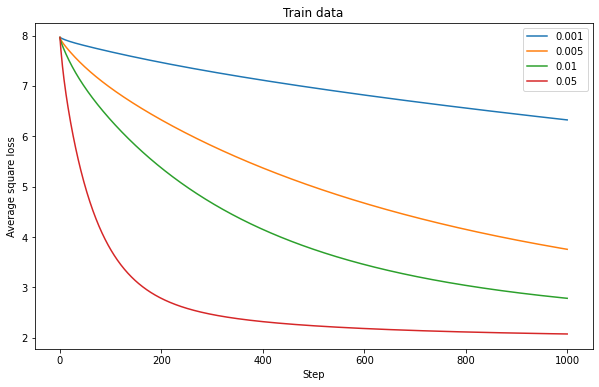

In [9]:
alpha_list = [0.001, 0.005, 0.01, 0.05]
plt.figure(figsize=(10,6))
for i in range(len(alpha_list)):
    theta_hist, loss_hist = batch_grad_descent(X_train, y_train, alpha=alpha_list[i], num_step=1000, grad_check=False)
    plt.plot(loss_hist, label=alpha_list[i])
plt.xlabel('Step')
plt.ylabel('Average square loss')
plt.title('Train data')
plt.legend()
plt.show()

Here, we can note that the average square loss as a function of step is affected by $\alpha$ such that lower values of $\alpha$ (i.e., $\alpha = 0.001$) produce much slower rates of learning than higher rates of $\alpha$ (i.e., $\alpha = 0.05)$. It is important to note that any value of $\alpha > 0.05$ causes gradient descent to diverge. Thus, we restricted our range of alphas to those seen above.

(13) For the learning rate you selected above, plot the average test loss as a function of the
iterations. You should observe overfitting: the test error first decreases and then increases.

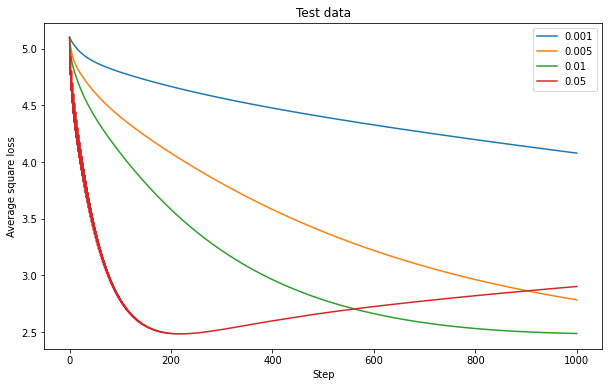

In [10]:
alpha_list = [0.001, 0.005, 0.01, 0.05]
plt.figure(figsize=(10,6))
for i in range(len(alpha_list)):
    theta_hist, loss_hist = batch_grad_descent(X_train, y_train, alpha=alpha_list[i], num_step=1000, grad_check=False)
    avg_test_loss = [compute_square_loss(X_test, y_test, theta) for theta in theta_hist]
    plt.plot(avg_test_loss, label=alpha_list[i])
plt.xlabel('Step')
plt.ylabel('Average square loss')
plt.title('Test data')
plt.legend()
plt.show()

#### Ridge regression

(14) Compute the gradient of $J_{\lambda}(\theta)$ and write down the expression for updating $\theta$ in the gradient descent algorithm. (Matrix/vector expression, without explicit summation)

$J_{\lambda}(\theta) = \frac{1}{m} \sum_{i=1}^m (h_{\theta} (x_i) - y_i)^2 + \lambda \theta^T \theta$

$J_{\lambda}(\theta) = \frac{1}{m} e^T e + \lambda \theta^T \theta$, where $e_i = h_{\theta} (x_i) - y_i$

$\nabla_{\theta} J_{\lambda}(\theta) = \frac{2}{m} X^T e + 2\lambda \theta$, where $e_i = h_{\theta} (x_i) - y_i$

$\nabla_{\theta} J_{\lambda}(\theta) = \frac{2}{m} X^T (X \theta - y) + 2\lambda \theta$

(15) Implement `compute_regularized_square_loss_gradient`.

In [11]:
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized average square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    return (2/X.shape[0])*X.T@(X@theta - y) + 2*lambda_reg*theta

(16) Implement `regularized_grad_descent`

In [12]:
def regularized_grad_descent(X, y, alpha=0.05, lambda_reg=10**-2, num_step=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        num_step - number of steps to run
    
    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                    for instance, theta in step 0 should be theta_hist[0], theta in step(num_step+1) is theta_hist[-1]
        loss hist - the history of average square loss function without the regularization term, 1D numpy array.
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.zeros(num_features) #Initialize theta
    theta_hist = np.zeros((num_step+1, num_features)) #Initialize theta_hist
    loss_hist = np.zeros(num_step+1) #Initialize loss_hist
    for i in range(num_step+1):
        theta_hist[i] = theta
        loss_hist[i] = compute_square_loss(X, y, theta)
        theta = theta - alpha*compute_regularized_square_loss_gradient(X, y, theta, lambda_reg)
    return theta_hist, loss_hist

(17) Choosing a reasonable step-size, plot training average square loss and the test average square loss (just the average square loss part, without the regularization, in each case) as a function of the training iterations for various values of $\lambda$. What do you notice in terms of overfitting?

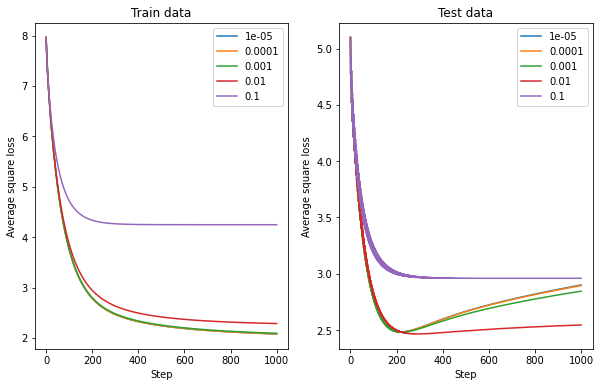

In [13]:
train_loss_lambda = []
train_loss_lambda_early = []
test_loss_lambda = []
test_loss_lambda_early = []
lambda_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
plt.figure(figsize=(10,6))
for i in range(len(lambda_list)):
    theta_hist, loss_hist = regularized_grad_descent(X_train, y_train, alpha=0.05, 
                                                     lambda_reg=lambda_list[i], num_step=1000)
    avg_test_loss = [compute_square_loss(X_test, y_test, theta) for theta in theta_hist]
    plt.subplot(1,2,1)
    plt.plot(loss_hist, label=lambda_list[i])
    plt.title('Train data')
    plt.xlabel('Step')
    plt.ylabel('Average square loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(avg_test_loss, label=lambda_list[i])
    plt.title('Test data')
    plt.xlabel('Step')
    plt.ylabel('Average square loss')
    plt.legend()
    train_loss_lambda.append(loss_hist[-1])
    train_loss_lambda_early.append(loss_hist[249])
    test_loss_lambda.append(avg_test_loss[-1])
    test_loss_lambda_early.append(avg_test_loss[249])

For the test data, overfitting begins after 250 steps for $\lambda = 0.00001, \lambda = 0.0001$ and $\lambda = 0.001$.

(18) Plot the training average square loss and the test average square loss at the end of training as a function of $\lambda$. You may want to have $log(\lambda)$ on the x-axis rather than $\lambda$. Which value of $\lambda$ would you choose ?

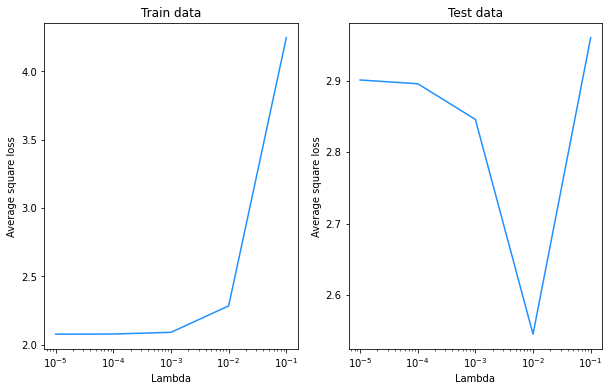

In [14]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(lambda_list, train_loss_lambda, color='dodgerblue')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Average square loss')
plt.title('Train data')
plt.subplot(1,2,2)
plt.plot(lambda_list, test_loss_lambda, color='dodgerblue')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Average square loss')
plt.title('Test data')
plt.show()

From the above plots we can see that $\lambda = 0.01$ is the optimal value because this is where the average square loss of the test data is minimal.

(19) Another heuristic of regularization is to early-stop the training when the test error reaches a minimum. Add to the last plot the minimum of the test average square loss along training as a function of $\lambda$. Is the value $\lambda$ you would select with early stopping the same as before?

Here, we will record the average square loss after 250 learning steps:

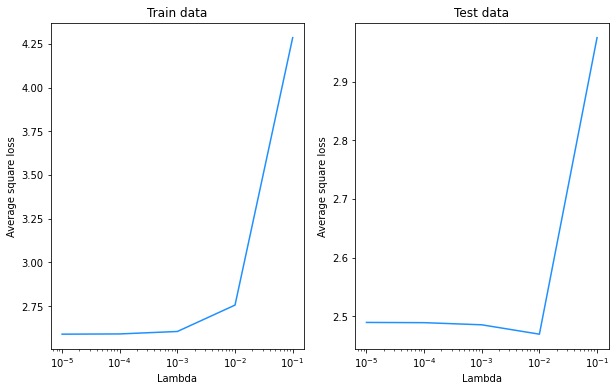

In [15]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(lambda_list, train_loss_lambda_early, color='dodgerblue')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Average square loss')
plt.title('Train data')
plt.subplot(1,2,2)
plt.plot(lambda_list, test_loss_lambda_early, color='dodgerblue')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Average square loss')
plt.title('Test data')
plt.show()

From the above plots we can see that $\lambda = 0.01$ is the optimal value once again because this is where the average square loss of the test data is minimal after 250 learning steps.

(20) What $\theta$ would you select in practice and why?

In practice, based on the average square loss seen above for the test data, I would select $\theta$ corresponding to $\lambda = 0.01$ and $k = 250$ learning steps.

### Stochastic gradient descent

(21) Show that the objective function

$J_{\lambda}(\theta) = \frac{1}{m} \sum_{i=1}^m (h_{\theta} (x_i) - y_i)^2 + \lambda \theta^T \theta$

can be written in the form $J_{\lambda}(\theta) = \frac{1}{m} \sum_{i=1}^m f_i(\theta)$ by giving an expression for $f_i(\theta)$ that makes the two expressions equivalent

$J_{\lambda}(\theta) = \frac{1}{m} \sum_{i=1}^m f_i (\theta)$, where $f_i(\theta) = (h_{\theta} (x_i) - y_i) + \frac{\lambda}{m} \theta^T \theta$

(22) Show that the stochastic gradient $\nabla_{\theta} f_i (\theta)$, for $i$ chosen uniformly at random from $\{1, ..., m\}$, is an unbiased estimator of $\nabla_{\theta} J_{\lambda} (\theta)$. In other words, show that $E[\nabla_{\theta} f_i (\theta)] = \nabla_{\theta} J_{\lambda} (\theta)$ for any $\theta$. It will be easier to prove this for a general $J_{\lambda}(\theta) = \frac{1}{m} \sum_{i=1}^m f_i (\theta)$, rather than the specific case of ridge regression. You can start by writing down an expression for $E[\nabla f_i (\theta)]$.

$E[\nabla_{\theta} f_i (\theta)] $

$= E[(2 h_{\theta} (x_i) - y_i) x_i + 2 \lambda \theta]$

$=E[\frac{2}{m} \sum_{i=1}^m (h_{\theta} (x_i) - y_i) x_i) + 2 \lambda \theta] $

$=\nabla_{\theta} J_{\lambda} (\theta)$

(23) Write down the update rule for $\theta$ in SGD for the ridge regression objective function.

$\theta^{i+1} = \theta^i - \eta \frac{2}{m} X^T (X \theta - y) + 2 \lambda \theta$

(24) Implement `stochastic_grad _descent`

In [16]:
def stochastic_grad_descent(X, y, alpha='0.01', lambda_reg=0.01, num_epoch=1000, c=0.1, eta0=False):
    """
    In this question you will implement stochastic gradient descent with regularization term

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - string or float, step size in gradient descent
                NOTE: In SGD, it's not a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every step is the float.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t).
                if alpha == "1/t", alpha = 1/t.
        lambda_reg - the regularization coefficient
        num_epoch - number of epochs to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size(num_epoch, num_instances, num_features)
                   for instance, theta in epoch 0 should be theta_hist[0], theta in epoch(num_epoch) is theta_hist[-1]
        loss hist - the history of loss function vector, 2D numpy array of size(num_epoch, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_epoch, num_instances, num_features)) #Initialize theta_hist
    loss_hist = np.zeros((num_epoch, num_instances)) #Initialize loss_hist
    for j in range(num_epoch):
        w = 0
        for i in range(num_instances):
            theta_hist[j][i] = theta
            if alpha=='1/sqrt(t)':
                step_size = c/np.sqrt(j+i+1)
            elif alpha=='1/t':
                step_size = c/(j+i+1)
            else:
                step_size = alpha
            rand_idx = np.random.randint(0, num_instances)
            X_i, y_i  = X[rand_idx,:], y[rand_idx]
            w += np.dot((X_i@theta - y_i), (X_i@theta - y_i)) + lambda_reg*np.dot(theta, theta)
            loss_hist[j][i] = w
            theta -= step_size*2*(np.dot((X_i@theta - y_i), X[rand_idx]) + lambda_reg*theta)
    return theta_hist, loss_hist

(25) Use SGD to find $\sigma_{\lambda}^*$ that minimizes the ridge regression objective for the $\lambda$ you selected
in the previous problem. Try a few fixed step sizes (at least try $\eta t \in \{0.05, 0.005\}$). Next try step sizes that decrease with the step number according to the following schedules: $\eta_t = \frac{C}{\sqrt t}$ and $\eta_t = \frac{C}{t}$, $C = 0.1$. For each step size rule, plot the value of the objective function (or the log of the objective function if that is more clear) as a function of epoch (or step number, if you prefer). How do the results compare?

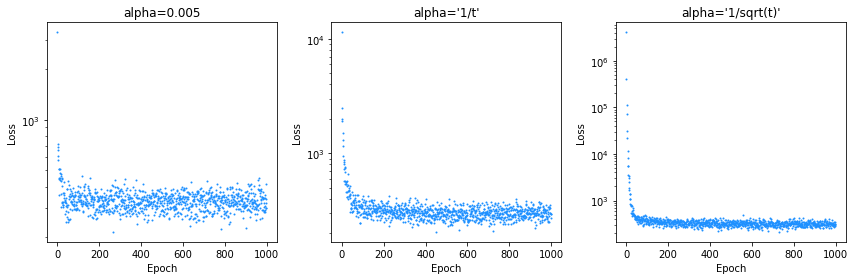

In [17]:
plt.figure(figsize=(12,4))
theta_hist, loss_hist = stochastic_grad_descent(X_train, y_train, alpha=0.005, lambda_reg=0.01, 
                                                num_epoch=1000, c=0.1, eta0=False)
plt.subplot(1,3,1)
plt.plot(loss_hist[:,-1], 'o', ms=1, color='dodgerblue')
plt.yscale('log')
plt.title("alpha=0.005")
plt.xlabel('Epoch')
plt.ylabel('Loss')

theta_hist, loss_hist = stochastic_grad_descent(X_train, y_train, alpha='1/t', lambda_reg=0.01, 
                                                num_epoch=1000, c=0.1, eta0=False)
plt.subplot(1,3,2)
plt.plot(loss_hist[:,-1], 'o', ms=1, color='dodgerblue')
plt.yscale('log')
plt.title("alpha='1/t'")
plt.xlabel('Epoch')
plt.ylabel('Loss')

theta_hist, loss_hist = stochastic_grad_descent(X_train, y_train, alpha='1/sqrt(t)', lambda_reg=0.01, 
                                                num_epoch=1000, c=0.1, eta0=False)
plt.subplot(1,3,3)
plt.plot(loss_hist[:,-1], 'o', ms=1, color='dodgerblue')
plt.yscale('log')
plt.title("alpha='1/sqrt(t)'")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

Here, we can directly observe the effect of a fixed alpha (in this case, $\alpha=0.005$ only, since $\alpha=0.05$ diverged) versus an adaptive one (here, $\alpha =\frac{c}{t}$ and $\alpha =\frac{c}{\sqrt{t}}$) on the loss. Clearly, with the adaptive rule we notice less variance in the loss and, moreover, faster convergence to the optimum.

## 3. Image classification with regularized logistic regression

In [18]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [19]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1')
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

Load `X_train`, `y_train`, `X_test`, `y_test` with `pre_process_mnist_01()`. Using the function `plt.imshow` from matplotlib visualize some data points from `X-train` by reshaping the 784 dimensional vectors into 28 × 28 arrays. Note how the class labels ‘0’ and ‘1’ have been encoded in `y_train`.

In [20]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()

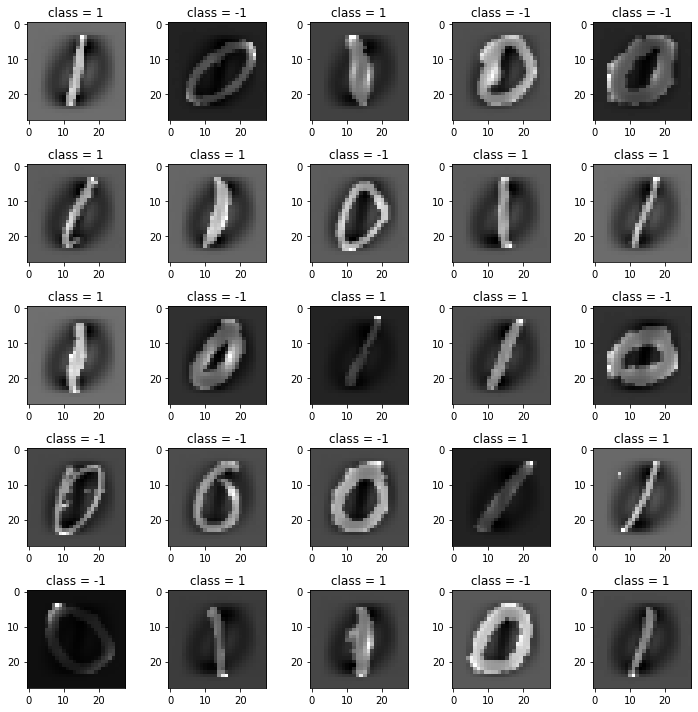

In [21]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,int(i+1))
    rand_idx = np.random.choice(len(X_train))
    plt.imshow(X_train[rand_idx].reshape(28,28), cmap='gray')
    plt.title('class = {}'.format(y_train[rand_idx]))
plt.tight_layout()
plt.show()

#### Logistic regression

(26) Recall the definition of the logistic loss between target $y$ and a prediction $h_{\theta, b} (x)$ as a function of the margin $m = yh_{\theta, b} (x)$. Show that given that we chose the convention $y_i \in \{-1,1\}$, our objective function over the training data $\{x_i, y_i\}_{i=1}^m$ can be re-written as:

$L(\theta) = \frac{1}{2M} \sum_{i=1}^m (1 + y_i)log(1 + e^{-h_{\theta,b}(x_i)}) + (1 - y_i)log(1 + e^{h_{\theta,b}(x_i)}).$

For $y_i = 1$:

$L(\theta) = \frac{1}{2M} \sum_{i=1}^m (1 + 1)log(1 + e^{-h_{\theta,b}(x_i)}) + (1 - 1)log(1 + e^{h_{\theta,b}(x_i)}) = \frac{1}{M} \sum_{i=1}^m log (1+e^{-h_{\theta,b}(x_i)})$

For $y_i = -1$:

$L(\theta) = \frac{1}{2M} \sum_{i=1}^m (1 - 1)log(1 + e^{-h_{\theta,b}(x_i)}) + (1 + 1)log(1 + e^{h_{\theta,b}(x_i)}) = \frac{1}{M} \sum_{i=1}^m log (1+e^{h_{\theta,b}(x_i)})$

(27) What will become the loss function if we regularize the coefficients of $\theta$ with an $\ell_1$ penalty using a regularization parameter $\alpha$?

$L(\theta) = \frac{1}{2M} \sum_{i=1}^m (1 + y_i)log(1 - e^{-h_{\theta,b}(x_i)}) + (1 - y_i)log(1 + e^{h_{\theta,b}(x_i)}) + \alpha \sum_{i=1}^m |\theta_i|$

(28) To evaluate the quality of our model we will use the classification error, which corresponds to the fraction of incorrectly labeled examples. For a given sample, the classification error is 1 if no example was labeled correctly and 0 if all examples were perfectly labeled. Using the method `clf.predict()` from the classifier write a function that takes as input an SGDClassifier which we will call `clf`, a design matrix `X` and a target vector `y` and returns the classification error. You should check that your function returns the same value as 1 - `clf.score(X, y)`.

In [22]:
def classification_error(clf, X, y):
    return 1 - sum(clf.predict(X)==y)/len(y)

In [23]:
clf = SGDClassifier(loss='log', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha=0.01, 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=1)
clf.fit(X_train, y_train)
print('Classification error:', classification_error(clf, X_test, y_test))
print('Output from sci-kit:', 1 - clf.score(X_test, y_test))

-- Epoch 1
Norm: 0.69, NNZs: 278, Bias: -0.006846, T: 9902, Avg. loss: 0.041371
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 0.78, NNZs: 246, Bias: -0.006398, T: 19804, Avg. loss: 0.031408
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 0.84, NNZs: 229, Bias: -0.005849, T: 29706, Avg. loss: 0.029808
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 0.89, NNZs: 222, Bias: -0.005312, T: 39608, Avg. loss: 0.028869
Total training time: 0.17 seconds.
-- Epoch 5
Norm: 0.92, NNZs: 218, Bias: -0.004750, T: 49510, Avg. loss: 0.028440
Total training time: 0.22 seconds.
-- Epoch 6
Norm: 0.96, NNZs: 210, Bias: -0.004191, T: 59412, Avg. loss: 0.028020
Total training time: 0.26 seconds.
-- Epoch 7
Norm: 0.99, NNZs: 207, Bias: -0.003647, T: 69314, Avg. loss: 0.027654
Total training time: 0.31 seconds.
-- Epoch 8
Norm: 1.01, NNZs: 206, Bias: -0.003097, T: 79216, Avg. loss: 0.027499
Total training time: 0.35 seconds.
Convergence after 8 epochs took 0.35 seconds
Classification error: 0.0010

To speed up computations we will subsample the data. Using the function `sub_sample`, restrict
`X_train` and `y_train` to `N_train' = 100.

In [24]:
def sub_sample(N_train, X_train, y_train):
    """
    Subsample the training data to keep only N first elements
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    assert N_train <= X_train.shape[0]
    return X_train[:N_train, :], y_train[:N_train]

In [25]:
N_train=100
X_train, y_train = sub_sample(N_train, X_train, y_train)
print(X_train.shape)
print(y_train.shape)

(100, 784)
(100,)


(29) Report the test classification error achieved by the logistic regression as a function of the regularization parameters $\alpha$ (taking $10$ values between $10^{−4}$ and $10^{−1}$). You should make a plot with $\alpha$ as the x-axis in log scale. For each value of $\alpha$, you should repeat the experiment $10$ times so as to finally report the mean value and the standard deviation. You should use `plt.errorbar` to plot the standard deviation as error bars.

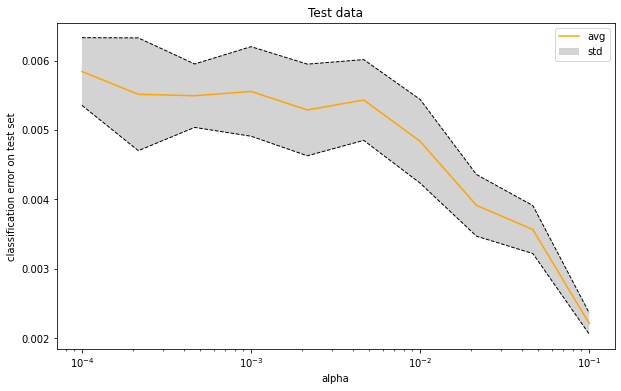

In [26]:
alpha = np.geomspace(1e-4, 1e-1, num=10)
alpha_avg = []
alpha_std = []
fitted_theta = []
for j in range(len(alpha)):
    err = []
    random_pick = np.random.randint(0,10)
    for i in range(10):
        clf = SGDClassifier(loss='log', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha=alpha[j], 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=False)
        clf.fit(X_train, y_train)
        err.append(classification_error(clf, X_test, y_test))
        if int(i)==random_pick:
            fitted_theta.append(clf.coef_)
    alpha_avg.append(np.mean(err))
    alpha_std.append(np.std(err))
alpha_avg = np.array(alpha_avg)
alpha_std = np.array(alpha_std)
plt.figure(figsize=(10,6))
plt.plot(alpha, alpha_avg, color='orange', label='avg')
plt.plot(alpha, alpha_avg+alpha_std, color='black', ls='--', lw=1)
plt.plot(alpha, alpha_avg-alpha_std, color='black', ls='--', lw=1)
plt.fill_between(alpha, alpha_avg+alpha_std, alpha_avg-alpha_std, facecolor='lightgrey', label='std')
plt.xlabel('alpha')
plt.ylabel('classification error on test set')
plt.title('Test data')
plt.xscale('log')
plt.legend()
plt.show()

(30) Which source(s) of randomness are we averaging over by repeating the experiment?

Through repeated experiments of subsampling from the data we are able to average over noisy classification error on the test set. The larger the number of experiments per value of $\alpha$, the more stable the estimate of the sample mean classification error rate.

(31) What is the optimal value of the parameter $\alpha\$ among the values you tested?

Based on the test set classification error for each of the values of $\alpha$ reported above, $\alpha = 0.1$ has the minimal classification error, so we conclude this is the optimal value.

(32) Finally, for one run of the fit for each value of $\alpha$ plot the value of the fitted $\theta$. You can access it via `clf.coef_`, and should reshape the 784 dimensional vector to a 28 × 28 array to visualize it with `plt.imshow`. Defining `scale = np.abs(clf.coef_).max()`, you can use the following keyword arguments `(cmap=plt.cm.RdBu, vmax=scale, vmin=-scale)` which will set the colors nicely in the plot. You should also use a `plt.colorbar()` to visualize the values associated with the colors.

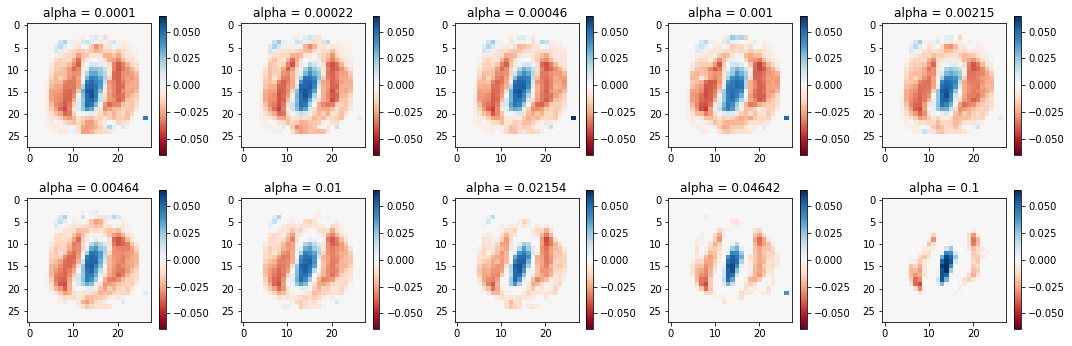

In [27]:
scale = np.abs(clf.coef_).max()
plt.figure(figsize=(15,5))
for i in range(len(alpha)):
    plt.subplot(2,5,int(i+1))
    plt.imshow(fitted_theta[i].reshape(28,28), cmap=plt.cm.RdBu, vmax=scale, vmin=-scale)
    plt.title('alpha = {}'.format(alpha[i].round(5)))
    plt.colorbar()
plt.tight_layout()
plt.show()

(33) What can you note about the pattern in $\theta$? What can you note about the effect of the regularization?

As we increase $\alpha$, we notice that the values of the fitted $\theta$ approach $0$ due to the effect of increasing the penalty in the regularization term. 